In [65]:
import sys
import importlib
sys.path.append('/home/ec2-user/SageMaker/Bias/')
import fairness
import torch
# importlib.reload(fairness.plots)

In [67]:
from fairness.data_simulation import DataGenerator
from fairness.split_data import perform_train_test_split
from fairness.models import Encoder, Predictor, Adversary
from fairness.init_networks import initialize_networks
from fairness.data_loaders import create_dataloaders
from fairness.training_components import initialize_training_components
from fairness.train import train_model
from fairness.plots import plot_lines,plot_comparison_heatmaps, plot_auc_roc_curve
from fairness.test import get_transformed_features, get_predictions
from fairness.eval import evaluate_classifier
from fairness.fairness_metrics import get_demographic_parity

In [5]:
num_non_sensitive = 4
num_sensitive = 1
generator = DataGenerator(num_non_sensitive = num_non_sensitive, num_sensitive = num_sensitive, seed=None)
data = generator.generate_simulated_data()
data

,X1,X2,X3,X4,S1,Y,Y_bayes
0,1.812836,0.396833,0.606136,0.725818,0,1,1.0000
1,-0.242688,0.625037,0.736785,1.516037,1,1,1.0000
2,1.975539,0.265362,0.226399,-0.229583,1,1,1.0000
3,-0.510727,0.797064,0.471204,1.322841,1,1,1.0000
4,1.747088,1.153864,0.825437,2.306041,0,1,1.0000
...,...,...,...,...,...,...,...
9995,-1.711932,-0.490533,0.442695,1.356561,0,0,0.0000
9996,-0.311728,0.363594,0.645972,1.505233,0,1,1.0000
9997,-1.905164,0.817389,0.255280,2.004928,0,0,0.0000
9998,1.918630,-0.109546,0.367887,-0.291676,0,1,0.3464


In [6]:
from sklearn.metrics import roc_auc_score
roc_auc_score(data['Y'],data['Y_bayes']) 

0.9974145852604047

In [7]:
data_train, data_test = perform_train_test_split(data, num_non_sensitive=num_non_sensitive, num_sensitive=num_sensitive, test_size=0.15)

print(data_train.shape, data_test.shape)

(8500, 6) (1500, 6)


In [8]:
encoder, predictor, adversaries = initialize_networks(Encoder, Predictor, Adversary, num_non_sensitive=num_non_sensitive, num_sensitive=num_sensitive)

train_loader, test_loader = create_dataloaders(data_train, data_test, batch_size=256, shuffle_train=True)

criterion_enc, criterion_pred, criterion_adversaries, optimizer_enc, optimizer_pred, optimizer_adversaries = initialize_training_components(encoder, predictor, adversaries, learning_rate=0.01)

In [16]:
adversaryA = adversaries[0]
criterion_advA = criterion_adversaries[0]
optimizer_advA = optimizer_adversaries[0]

In [21]:
epochs_total = []
gradient_norms_enc = []
gradient_norms_pred = []
gradient_norms_advA = []
loss_enc = []
loss_pred = []
loss_advA = []
loss_comb = []

In [45]:
num_epochs = 100

In [11]:
def calculate_gradient(model):
    batch_gradient_norm = 0.0
    for p in model.parameters():
        if p.grad is not None:
            batch_gradient_norm += p.grad.data.norm(2).item() ** 2
    batch_gradient_norm = batch_gradient_norm ** 0.5
    return batch_gradient_norm

In [46]:
for epoch in range(num_epochs):
    
    total_gradient_norm_A = 0.0
    total_gradient_norm_enc = 0.0
    total_gradient_norm_pred = 0.0
    num_batches_adv = 0
    num_batches_other = 0

    for data, labels in train_loader: 
        A = data[:,-1].view(-1,1).float()
        len_A0Y0 = ((A == 0) & (labels == 0)).sum().item()
        len_A0Y1 = ((A == 0) & (labels == 1)).sum().item()
        len_A1Y0 = ((A == 1) & (labels == 0)).sum().item()
        len_A1Y1 = ((A == 1) & (labels == 1)).sum().item()
        total_length = len_A0Y0 + len_A0Y1 + len_A1Y0 + len_A1Y1
        A0Y0 = len_A0Y0 / total_length
        A0Y1 = len_A0Y1 / total_length
        A1Y0 = len_A1Y0 / total_length
        A1Y1 = len_A1Y1 / total_length
        AY_proportion = [[A0Y0, A0Y1], [A1Y0, A1Y1]]
        A_prop = [AY_proportion[0][0] + AY_proportion[0][1], AY_proportion[1][0] + AY_proportion[1][1]]
        Y_prop = [AY_proportion[0][0] + AY_proportion[1][0], AY_proportion[0][1] + AY_proportion[1][1]]
        wts = A_prop[0] * (1 - A) + A_prop[1] * A
        
        adversaryA.zero_grad()
        x_recon = encoder(data)
        adv_predA = adversaryA(x_recon)
        laA = criterion_advA(adv_predA, data[:,4].view(-1,1).float())
        weighted_laA = torch.mean(laA * torch.squeeze(wts))

        weighted_laA.backward()        
        
        batch_gradient_norm_A = calculate_gradient(adversaryA)
        total_gradient_norm_A += batch_gradient_norm_A

        num_batches_adv += 1

        torch.nn.utils.clip_grad_norm_(encoder.parameters(), 1.0)
        torch.nn.utils.clip_grad_norm_(predictor.parameters(), 1.0)
        torch.nn.utils.clip_grad_norm_(adversaryA.parameters(), 1.0)

        optimizer_advA.step()
        
    for data, labels in train_loader: 
        pass
    
    encoder.zero_grad()
    predictor.zero_grad()
    x_recon = encoder(data)
    y_pred = predictor(x_recon)
    adv_predA = adversaryA(x_recon)

    lx = criterion_enc(x_recon, data[:,:4])
    lp = criterion_pred(y_pred, labels)
    laA = criterion_advA(adv_predA, data[:,4].view(-1,1).float())
    weighted_laA = torch.mean(laA * torch.squeeze(wts))

    combined_loss = lx + lp - (10 * (weighted_laA))
    combined_loss.backward()

    batch_gradient_norm_A = calculate_gradient(adversaryA)
    total_gradient_norm_A += batch_gradient_norm_A
    
    batch_gradient_norm_enc = calculate_gradient(encoder)
    total_gradient_norm_enc += batch_gradient_norm_enc

    batch_gradient_norm_pred = calculate_gradient(predictor)
    total_gradient_norm_pred += batch_gradient_norm_pred


    num_batches_other += 1
    num_batches_adv += 1
    torch.nn.utils.clip_grad_norm_(encoder.parameters(), 1.0)
    torch.nn.utils.clip_grad_norm_(predictor.parameters(), 1.0)
    torch.nn.utils.clip_grad_norm_(adversaryA.parameters(), 1.0)

    optimizer_pred.step()
    optimizer_enc.step()
    
    average_gradient_norm_A = total_gradient_norm_A / num_batches_adv
    gradient_norms_advA.append(average_gradient_norm_A)
    
    average_gradient_norm_enc = total_gradient_norm_enc / num_batches_other
    gradient_norms_enc.append(average_gradient_norm_enc)

    average_gradient_norm_pred = total_gradient_norm_pred / num_batches_other
    gradient_norms_pred.append(average_gradient_norm_pred)
    
    loss_advA.append(laA.item())
    loss_enc.append(lx.item())
    loss_pred.append(lp.item())
    loss_comb.append(combined_loss.item())

    epochs_total.append(epoch)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss A: {laA.item():.4f}, Loss Recon: {lx.item():.4f}, Loss P: {lp.item():.4f}, Loss Comb: {combined_loss.item():.4f}')

Epoch [1/100], Loss A: 0.3033, Loss Recon: 0.1859, Loss P: 0.5627, Loss Comb: -0.7678
Epoch [2/100], Loss A: 0.3135, Loss Recon: 0.2147, Loss P: 0.4504, Loss Comb: -1.0903
Epoch [3/100], Loss A: 0.2747, Loss Recon: 0.2063, Loss P: 0.5044, Loss Comb: -0.6955
Epoch [4/100], Loss A: 0.2889, Loss Recon: 0.2182, Loss P: 0.4044, Loss Comb: -0.8238
Epoch [5/100], Loss A: 0.2783, Loss Recon: 0.2372, Loss P: 0.4017, Loss Comb: -0.8266
Epoch [6/100], Loss A: 0.2859, Loss Recon: 0.1910, Loss P: 0.3759, Loss Comb: -0.8964
Epoch [7/100], Loss A: 0.2783, Loss Recon: 0.1919, Loss P: 0.4807, Loss Comb: -0.7375
Epoch [8/100], Loss A: 0.2951, Loss Recon: 0.1902, Loss P: 0.4869, Loss Comb: -0.8530
Epoch [9/100], Loss A: 0.3026, Loss Recon: 0.1612, Loss P: 0.3437, Loss Comb: -1.2790
Epoch [10/100], Loss A: 0.3073, Loss Recon: 0.1896, Loss P: 0.7254, Loss Comb: -0.6304
Epoch [11/100], Loss A: 0.3174, Loss Recon: 0.1717, Loss P: 0.5867, Loss Comb: -0.8663
Epoch [12/100], Loss A: 0.3353, Loss Recon: 0.1880, 

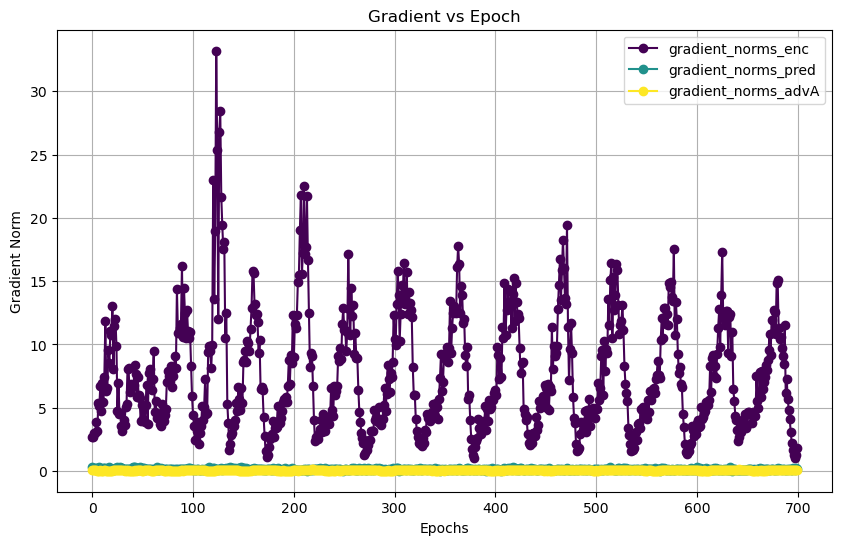

In [60]:
plot_lines(range(len(epochs_total)), gradient_norms_enc,gradient_norms_pred, gradient_norms_advA, labels=['gradient_norms_enc', 'gradient_norms_pred', 'gradient_norms_advA'], title='Gradient vs Epoch', xlabel='Epochs', ylabel='Gradient Norm')

In [48]:
new_df = get_transformed_features(test_loader, data_test, num_non_sensitive, num_sensitive, encoder)

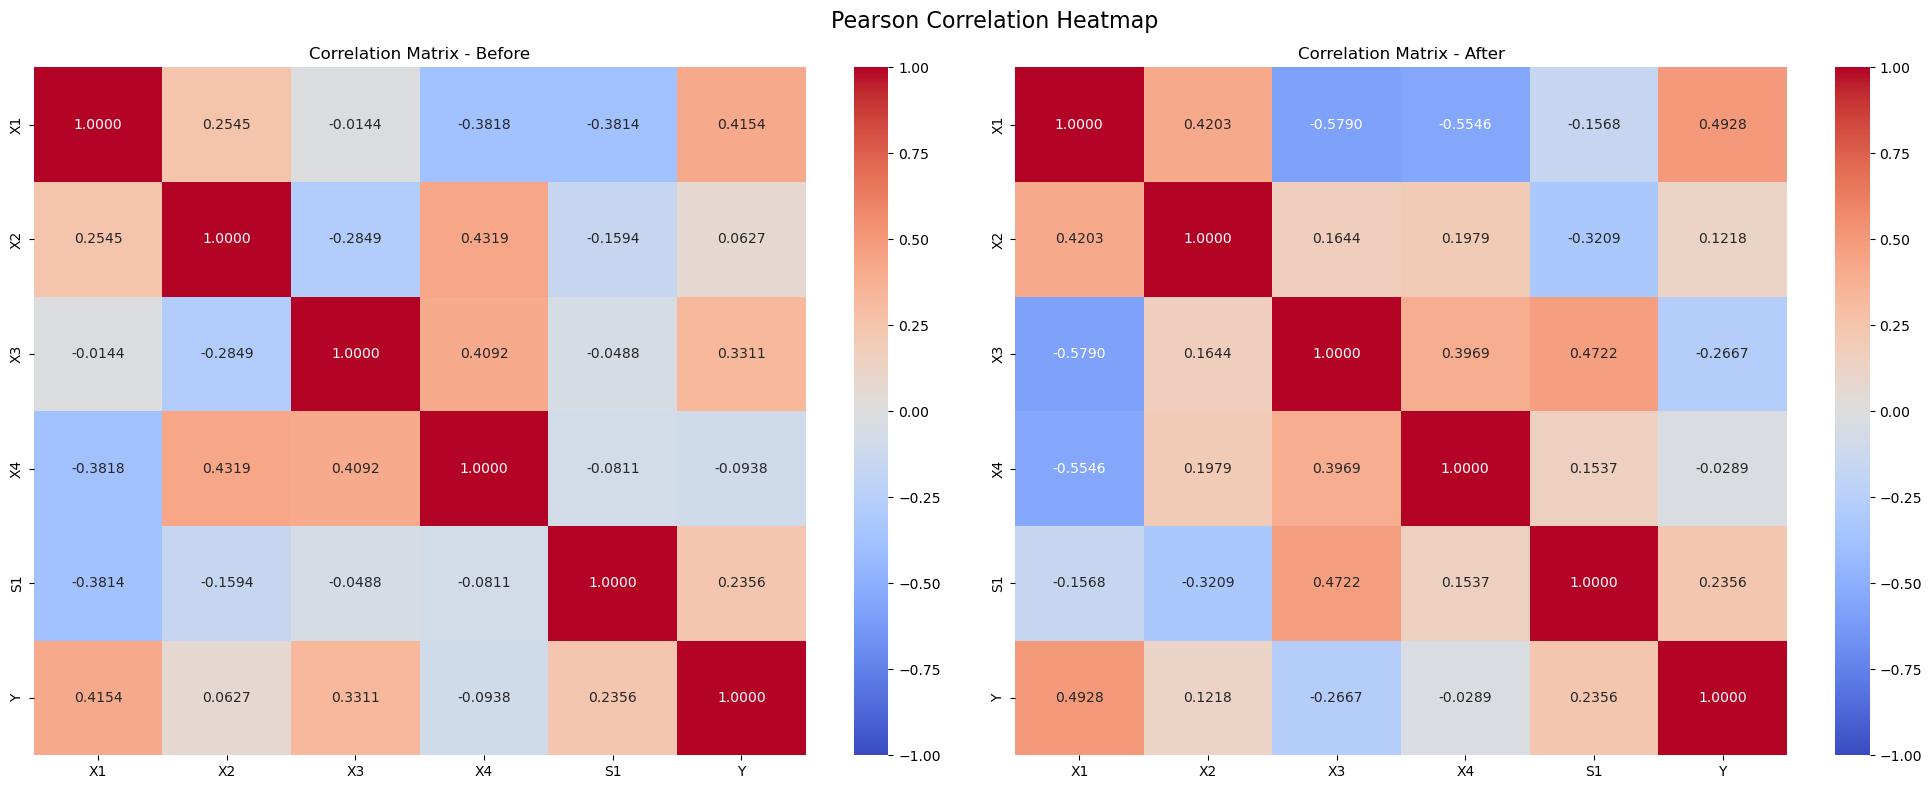

In [63]:
plot_comparison_heatmaps(data_test, new_df, figsize=(20, 8), cmap='coolwarm', vmin=-1, vmax=1)

In [50]:
y_true, y_logits, y_pred = get_predictions(data_test, num_non_sensitive, num_sensitive, encoder, predictor, threshold=0.5)

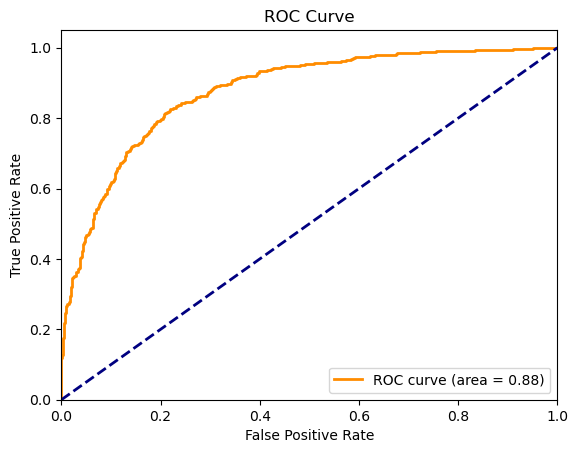

In [68]:
plot_auc_roc_curve(y_true, y_logits, title='ROC Curve')

In [53]:
metrics = evaluate_classifier(y_true, y_pred, y_logits)

for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

Accuracy: 0.8047
Precision: 0.8181
Recall: 0.8422
F1 Score: 0.8299
ROC AUC Score: 0.8763


In [54]:
all_group_stats, all_demographic_parity = get_demographic_parity(y_true, y_pred, data_test, num_sensitive)

for sensitive_var, stat in all_group_stats.items():
    print(f"Group stats for sensitive variable: {sensitive_var}")
    print(stat)

    print('\n\n')

for sensitive_var, dp in all_demographic_parity.items():
    print(f"Demographic parity for sensitive variable: {sensitive_var}")
    print(dp)

Group stats for sensitive variable: S1
    total_predictions  positive_predictions  positive_prediction_rate
S1                                                                   
0                 834                   489                  0.586331
1                 666                   385                  0.578078



Demographic parity for sensitive variable: S1
0.008252857173720485
